# First-Order Markov Chain Computation

This portion 1. Preprocess dataset and build a first-order Markov baseline.


In [ ]:
import numpy as np
import pandas as pd
from pprint import pprint

# Read and preprocess
df = pd.read_csv('nyc_temperature.csv')
# drop columns not needed (if present)
for c in ['tmax','tmin','departure','HDD','CDD','snow_depth']:
    if c in df.columns:
        df = df.drop(columns=[c])
# replace 'T' (trace) with 0 in precipitation/new_snow if present
if 'precipitation' in df.columns:
    df['precipitation'].replace(to_replace='T', value=0, inplace=True)
if 'new_snow' in df.columns:
    df['new_snow'].replace(to_replace='T', value=0, inplace=True)

# Ensure tavg numeric and fill small gaps
df['tavg'] = pd.to_numeric(df['tavg'], errors='coerce')
df['tavg'].fillna(method='ffill', inplace=True)
df['tavg'].fillna(method='bfill', inplace=True)
df['tavg'].fillna(df['tavg'].mean(), inplace=True)

# Simple categorization used previously
def categorize_weather(row):
    try:
        if float(row.get('precipitation',0)) >= 0.1:
            return 'Rainy'
        elif float(row.get('new_snow',0)) > 0:
            return 'Snowy'
        elif float(row.get('tavg',0)) >= 60:
            return 'Sunny'
        else:
            return 'Cloudy'
    except Exception:
        return 'Cloudy'

df['weather'] = df.apply(categorize_weather, axis=1)

states = ['Sunny', 'Cloudy', 'Rainy', 'Snowy']
state_index = {s:i for i,s in enumerate(states)}
observations = df['tavg'].astype(float).values
labels = np.array(df['weather'].values)

# Build first-order Markov transition matrix from the full available labels as a baseline, and compute train-only below
transition_counts = np.zeros((len(states), len(states)))
for i in range(len(labels)-1):
    transition_counts[state_index[labels[i]], state_index[labels[i+1]]] += 1
transition_matrix_full = transition_counts / (transition_counts.sum(axis=1, keepdims=True) + 1e-12)

print('Data loaded: N=', len(df))
print('Example rows:')
print(df[['date','tavg','precipitation','new_snow','weather']].head().to_string(index=False))


Data loaded: N= 365
Example rows:
  date  tavg precipitation new_snow weather
1/1/19  50.0          0.08        0  Cloudy
2/1/19  38.0             0        0  Cloudy
3/1/19  42.0             0        0  Cloudy
4/1/19  42.0             0        0  Cloudy
5/1/19  44.5          0.45        0   Rainy


/var/folders/3d/h1dh8n9d4tscknh3l61lzh1w0000gn/T/ipykernel_94772/86010937.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['tavg'].fillna(method='ffill', inplace=True)
/var/folders/3d/h1dh8n9d4tscknh3l61lzh1w0000gn/T/ipykernel_94772/86010937.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['tavg'].fillna(method='bfill', inplace=True)


# HMM 1-day-ahead forecasting (NYC 2019)

This portion trains a Gaussian-emission Hidden Markov Model (HMM) on daily average temperature (`tavg`) and evaluates 1-day-ahead categorical forecasting (weather categories) out-of-sample. 

Steps:
1. Train Gaussian HMM via Baum–Welch on training portion.
2. Learn mapping P(category | hidden_state) from training labels.
3. Evaluate 1-day-ahead forecasting accuracy on test set for Markov and HMM (K=2,3).


In [3]:
# HMM implementation (1D Gaussian emissions) + evaluation for 1-day ahead forecasting

def init_hmm_params(K, observations, random_state=0):
    rng = np.random.default_rng(random_state)
    pi = np.ones(K) / K
    A = rng.random((K, K))
    A = A / A.sum(axis=1, keepdims=True)
    qs = np.linspace(0, 100, K + 2)[1:-1]
    means = np.percentile(observations, qs)
    overall_std = np.std(observations) if np.std(observations) > 0 else 1.0
    stds = np.ones(K) * max(overall_std / 2, 1e-2)
    return pi, A, means.astype(float), stds.astype(float)


def gaussian_pdf_vec(x, means, stds):
    x = np.asarray(x)
    K = len(means)
    if x.ndim == 0:
        return np.array([1.0 / (np.sqrt(2 * np.pi) * stds[k]) * np.exp(-0.5 * ((x - means[k]) / stds[k])**2) for k in range(K)])
    T = x.shape[0]
    B = np.zeros((T, K))
    for k in range(K):
        var = stds[k]**2 + 1e-12
        B[:, k] = (1.0 / np.sqrt(2 * np.pi * var)) * np.exp(-0.5 * (x - means[k])**2 / var)
    return B


def forward_backward_scaled(obs, pi, A, means, stds):
    T = len(obs)
    K = len(pi)
    B = gaussian_pdf_vec(obs, means, stds)
    alpha = np.zeros((T, K))
    beta = np.zeros((T, K))
    c = np.zeros(T)
    alpha[0] = pi * B[0]
    c[0] = alpha[0].sum()
    if c[0] <= 0:
        c[0] = 1e-12
    alpha[0] = alpha[0] / c[0]
    for t in range(1, T):
        alpha[t] = (alpha[t-1] @ A) * B[t]
        c[t] = alpha[t].sum()
        if c[t] <= 0:
            c[t] = 1e-12
        alpha[t] = alpha[t] / c[t]
    beta[-1] = 1.0
    for t in range(T - 2, -1, -1):
        beta[t] = (A * (B[t+1] * beta[t+1])).sum(axis=1)
        beta[t] = beta[t] / (c[t+1] if c[t+1] != 0 else 1e-12)
    gamma = alpha * beta
    xi_sum = np.zeros((K, K))
    for t in range(T - 1):
        denom = (alpha[t][:, None] * A) * (B[t+1] * beta[t+1])[None, :]
        s = denom.sum()
        if s <= 0:
            s = 1e-12
        xi_sum += denom / s
    loglik = np.sum(np.log(c + 1e-12))
    return alpha, beta, gamma, xi_sum, loglik

## Parameter Estimation via Baum–Welch. 
def baum_welch(obs, K, max_iter=100, tol=1e-4, random_state=0):
    pi, A, means, stds = init_hmm_params(K, obs, random_state=random_state)
    prev_loglik = -np.inf
    for it in range(max_iter):
        alpha, beta, gamma, xi_sum, loglik = forward_backward_scaled(obs, pi, A, means, stds)
        T = len(obs)
        pi = gamma[0] / (gamma[0].sum() + 1e-12)
        row_sums = gamma[:-1].sum(axis=0) + 1e-12
        for j in range(K):
            A[j] = xi_sum[j] / row_sums[j]
        A = np.where(A < 1e-12, 1e-12, A)
        A = A / A.sum(axis=1, keepdims=True)
        Nk = gamma.sum(axis=0) + 1e-12
        for k in range(K):
            means[k] = (gamma[:, k] @ obs) / Nk[k]
            var = (gamma[:, k] @ ((obs - means[k])**2)) / Nk[k]
            stds[k] = np.sqrt(max(var, 1e-6))
        if it > 0 and abs(loglik - prev_loglik) < tol:
            break
        prev_loglik = loglik
    return pi, A, means, stds, loglik


def learn_mapping_hidden_to_cats(obs, labels, pi, A, means, stds, cats, cat_to_idx):
    _, _, gamma, _, _ = forward_backward_scaled(obs, pi, A, means, stds)
    K = len(pi)
    C = len(cats)
    M = np.zeros((K, C))
    for t, lab in enumerate(labels):
        cidx = cat_to_idx[lab]
        M[:, cidx] += gamma[t]
    row_sums = M.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1e-12
    M = M / row_sums
    return M


def evaluate_1day_ahead_out_of_sample(obs, labels, cat_to_idx, train_frac=0.8, Ks=[2, 3]):
    N = len(obs)
    split = int(N * train_frac)
    obs_train = obs[:split]
    labels_train = labels[:split]
    obs_test = obs[split:]
    labels_test = labels[split:]

    # Markov baseline from training labels
    trans_counts = np.zeros((len(states), len(states)))
    for i in range(len(labels_train) - 1):
        cur = labels_train[i]
        nxt = labels_train[i + 1]
        trans_counts[cat_to_idx[cur], cat_to_idx[nxt]] += 1

    # Laplace (add-one) smoothing
    alpha = 1.0
    row_sums = trans_counts.sum(axis=1, keepdims=True) + alpha * len(states)
    trans = (trans_counts + alpha) / row_sums

    preds_markov = []
    log_losses_markov = []
    briers_markov = []

    # Markov accuracy on test: predict t+1 using true label at t (available at prediction time as category)
    for i in range(len(labels_test) - 1):
        today = labels_test[i]
        true_label = labels_test[i + 1]

        probs = trans[cat_to_idx[today]]          # predictive distribution over categories
        pred_label = states[int(np.argmax(probs))]

        preds_markov.append(pred_label)

        # log loss for true label
        p_true = probs[cat_to_idx[true_label]]
        log_losses_markov.append(-np.log(max(p_true, 1e-12)))

        # Brier score
        y_true = np.zeros(len(states))
        y_true[cat_to_idx[true_label]] = 1.0
        briers_markov.append(np.sum((probs - y_true) ** 2))

    true_markov = labels_test[1:]
    acc_markov = np.mean([p == t for p, t in zip(preds_markov, true_markov)])
    avg_logloss_markov = np.mean(log_losses_markov)
    avg_brier_markov = np.mean(briers_markov)

    results = {
        'markov_acc': acc_markov,
        'markov_logloss': avg_logloss_markov,
        'markov_brier': avg_brier_markov,
    }

    # For each K, train HMM on obs_train and evaluate rolling predictions on test
    for K in Ks:
        pi_h, A_h, means_h, stds_h, loglik = baum_welch(
            obs_train, K, max_iter=200, tol=1e-4, random_state=1
        )
        # mapping from hidden->categories using training labels and obs_train
        M = learn_mapping_hidden_to_cats(
            obs_train, labels_train, pi_h, A_h, means_h, stds_h, states, cat_to_idx
        )

        preds_hmm = []
        log_losses_hmm = []
        briers_hmm = []

        # compute alpha once for whole sequence (train+test) using trained parameters
        obs_all = np.concatenate([obs_train, obs_test])
        alpha_all, _, _, _, _ = forward_backward_scaled(
            obs_all, pi_h, A_h, means_h, stds_h
        )

        # Global index i runs over the whole sequence; test segment starts at split
        for i in range(split, split + len(obs_test) - 1):
            alpha_t = alpha_all[i]           # filtered hidden distribution at time i
            pred_hidden_next = alpha_t @ A_h
            pred_cat_probs = pred_hidden_next @ M   # predictive distribution over categories

            # point prediction
            pred_label = states[int(np.argmax(pred_cat_probs))]
            preds_hmm.append(pred_label)

            # true label at time i+1
            true_label = labels[i + 1]

            # log loss for true label
            p_true = pred_cat_probs[cat_to_idx[true_label]]
            log_losses_hmm.append(-np.log(max(p_true, 1e-12)))

            # Brier score
            y_true = np.zeros(len(states))
            y_true[cat_to_idx[true_label]] = 1.0
            briers_hmm.append(np.sum((pred_cat_probs - y_true) ** 2))

        true_hmm = labels[split + 1 : split + len(obs_test)]
        acc_hmm = np.mean([p == t for p, t in zip(preds_hmm, true_hmm)])
        avg_logloss_hmm = np.mean(log_losses_hmm)
        avg_brier_hmm = np.mean(briers_hmm)

        results[f'hmm_K_{K}_acc'] = acc_hmm
        results[f'hmm_K_{K}_logloss'] = avg_logloss_hmm
        results[f'hmm_K_{K}_brier'] = avg_brier_hmm


    return results

# Run evaluation
results = evaluate_1day_ahead_out_of_sample(observations, labels, state_index, train_frac=0.8, Ks=[2,3])
print('Out-of-sample 1-day-ahead accuracies:')
pprint(results)


Out-of-sample 1-day-ahead accuracies:
{'hmm_K_2_acc': 0.6805555555555556,
 'hmm_K_2_brier': 0.4846620040770431,
 'hmm_K_2_logloss': 0.8810521391506163,
 'hmm_K_3_acc': 0.6805555555555556,
 'hmm_K_3_brier': 0.5049181739951474,
 'hmm_K_3_logloss': 0.8409196743940012,
 'markov_acc': 0.6666666666666666,
 'markov_brier': 0.47244598032231205,
 'markov_logloss': 0.8653580265090547}


Accuracies:
Markov: 0.6667
HMM K=2: 0.6806
HMM K=3: 0.6806
Baseline (Sunny): 0.0556


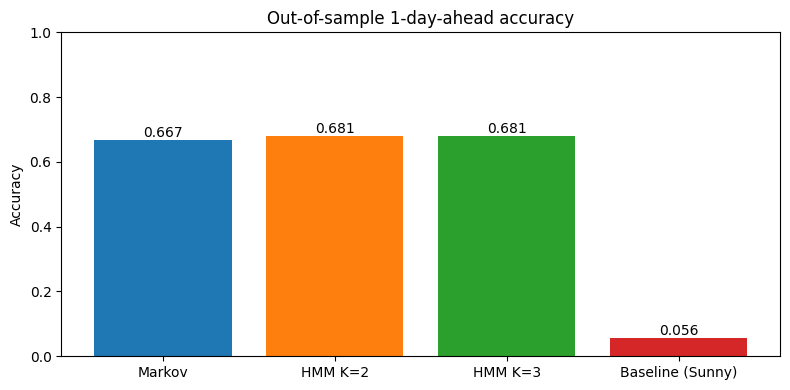

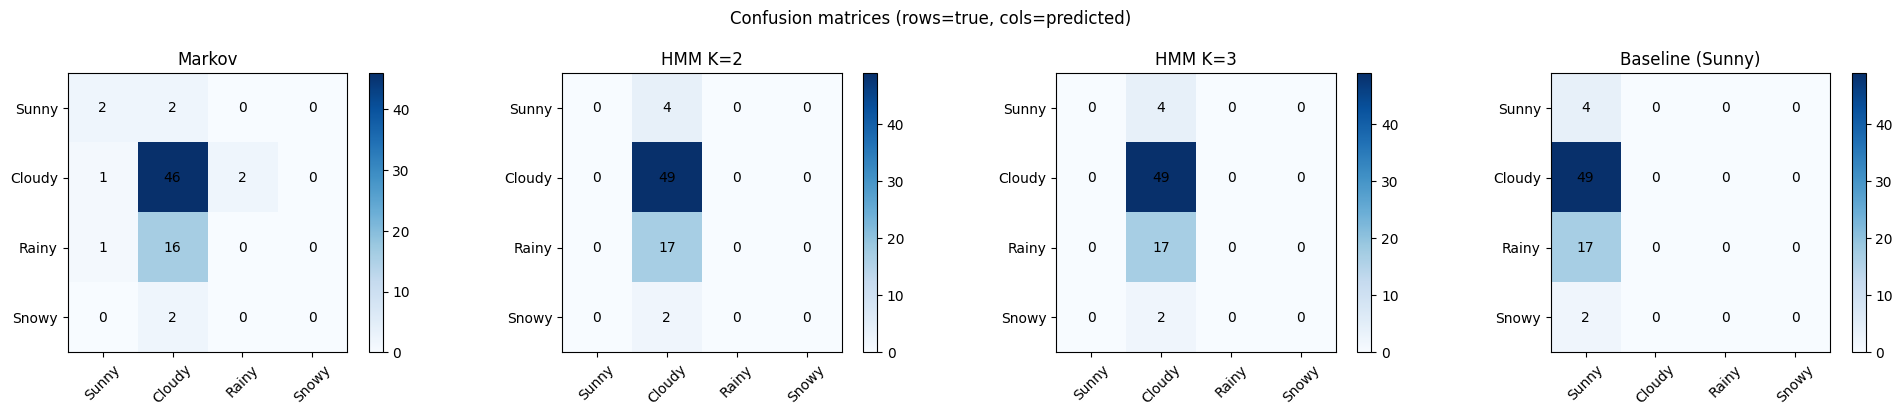

In [4]:
# Visualize 1-day-ahead accuracy and confusion matrices for Markov, HMM(K=2), HMM(K=3), and baseline
import matplotlib.pyplot as plt
import numpy as np

# Recreate train/test split used earlier
N = len(observations)
split = int(N * 0.8)
obs_train = observations[:split]
labels_train = labels[:split]
obs_test = observations[split:]
labels_test = labels[split:]

# Markov baseline trained on training labels
trans_counts = np.zeros((len(states), len(states)))
for i in range(len(labels_train)-1):
    trans_counts[state_index[labels_train[i]], state_index[labels_train[i+1]]] += 1
trans = trans_counts / (trans_counts.sum(axis=1, keepdims=True) + 1e-12)

# Markov predictions for test (predict t+1 from today's true label)
preds_markov = []
for i in range(len(labels_test)-1):
    today = labels_test[i]
    probs = trans[state_index[today]]
    preds_markov.append(states[int(np.argmax(probs))])
true_markov = labels_test[1:]
acc_markov = np.mean([p==t for p,t in zip(preds_markov, true_markov)])

# Baseline: always predict most frequent label in training set
most_freq = pd.Series(labels_train).mode().iloc[0]
preds_baseline = [most_freq] * (len(labels_test)-1)
acc_baseline = np.mean([p==t for p,t in zip(preds_baseline, true_markov)])

# HMM predictions for K=2 and K=3
results_preds = {}
for K in [2, 3]:
    pi_h, A_h, means_h, stds_h, loglik = baum_welch(obs_train, K, max_iter=200, tol=1e-4, random_state=1)
    M = learn_mapping_hidden_to_cats(obs_train, labels_train, pi_h, A_h, means_h, stds_h, states, state_index)
    obs_all = np.concatenate([obs_train, obs_test])
    alpha_all, _, _, _, _ = forward_backward_scaled(obs_all, pi_h, A_h, means_h, stds_h)
    preds_hmm = []
    for i in range(split, split + len(obs_test) - 1):
        alpha_t = alpha_all[i]
        pred_hidden_next = alpha_t @ A_h
        pred_cat_probs = pred_hidden_next @ M
        preds_hmm.append(states[int(np.argmax(pred_cat_probs))])
    true_hmm = labels[split+1: split+len(obs_test)]
    acc_hmm = np.mean([p==t for p,t in zip(preds_hmm, true_hmm)])
    results_preds[f'hmm_K_{K}'] = {'preds': preds_hmm, 'acc': acc_hmm}

# Collect accuracies
accuracies = {
    'Markov': acc_markov,
    'HMM K=2': results_preds['hmm_K_2']['acc'],
    'HMM K=3': results_preds['hmm_K_3']['acc'],
    f'Baseline ({most_freq})': acc_baseline
}

print('Accuracies:')
for k,v in accuracies.items():
    print(f'{k}: {v:.4f}')

# Bar chart of accuracies
plt.figure(figsize=(8,4))
names = list(accuracies.keys())
vals = [accuracies[n] for n in names]
bars = plt.bar(names, vals, color=['C0','C1','C2','C3'])
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Out-of-sample 1-day-ahead accuracy')
for bar, v in zip(bars, vals):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.01, f'{v:.3f}', ha='center')
plt.tight_layout()
plt.show()

# Helper to compute confusion matrix (true vs predicted)
def confusion_matrix_counts(true, pred, cats, cat_to_idx):
    C = len(cats)
    cm = np.zeros((C, C), dtype=int)
    for t, p in zip(true, pred):
        cm[cat_to_idx[t], cat_to_idx[p]] += 1
    return cm

# Plot confusion matrices: order = Markov, HMM K=2, HMM K=3, Baseline
fig, axes = plt.subplots(1,4, figsize=(20,4))
models = ['Markov', 'HMM K=2', 'HMM K=3', f'Baseline ({most_freq})']
pred_lists = [preds_markov, results_preds['hmm_K_2']['preds'], results_preds['hmm_K_3']['preds'], preds_baseline]
true_lists = [true_markov, true_hmm, true_hmm, true_markov]

for ax, name, true_l, pred_l in zip(axes, models, true_lists, pred_lists):
    cm = confusion_matrix_counts(true_l, pred_l, states, state_index)
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(name)
    ax.set_xticks(range(len(states)))
    ax.set_yticks(range(len(states)))
    ax.set_xticklabels(states, rotation=45)
    ax.set_yticklabels(states)
    # annotate
    for i in range(len(states)):
        for j in range(len(states)):
            ax.text(j, i, str(cm[i,j]), ha='center', va='center', color='black')
    fig.colorbar(im, ax=ax)

plt.suptitle('Confusion matrices (rows=true, cols=predicted)')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [5]:
cat_to_idx = {s: i for i, s in enumerate(states)}


# Run evaluation: Markov vs HMM K=2,3
results = evaluate_1day_ahead_out_of_sample(
    obs=observations,    
    labels=labels,      
    cat_to_idx=cat_to_idx,
    train_frac=0.8,
    Ks=[2, 3]
)


print("=== 1-day-ahead performance on test set ===")
print(f"Markov:   acc = {results['markov_acc']:.3f}, "
      f"log loss = {results['markov_logloss']:.3f}, "
      f"Brier = {results['markov_brier']:.3f}")


for K in [2, 3]:
    print(f"HMM K={K}: acc = {results[f'hmm_K_{K}_acc']:.3f}, "
          f"log loss = {results[f'hmm_K_{K}_logloss']:.3f}, "
          f"Brier = {results[f'hmm_K_{K}_brier']:.3f}")


=== 1-day-ahead performance on test set ===
Markov:   acc = 0.667, log loss = 0.865, Brier = 0.472
HMM K=2: acc = 0.681, log loss = 0.881, Brier = 0.485
HMM K=3: acc = 0.681, log loss = 0.841, Brier = 0.505
